# Simple GP Regression 

Gaussian processes are a powerful tool for nonlinear regression models. 

Assume that we have **predictor** variables $\mathbf{X} = \{\mathbf{x_i}\}_{i=1}^N \in \mathbb{R}^d$ and **response** variables $\mathbf{y}=\{y_i \in \mathbb{R}\}_{i=1}^N$.

The response variables $\mathbf{y}$ are assumed to dependent on the predictors $\mathbf{X}$,

\begin{equation}
y_i \sim \mathcal{N}(f(\mathbf{x}_i),\sigma^2), \ i=1,\ldots,n,  
\end{equation}

where $f$ is a mapping function. Treating $f$ as a random function, we assume that the distribution over $f$ is a **Gaussian process**,
$$
f \sim \mathcal{GP}(m(\mathbf{x}),k(\mathbf{x},\mathbf{x}')),
$$
where $m(\cdot)$ and $k(\cdot,\cdot)$ are the mean and kernel functions respectively.

## 1D regression example

We start by simulating some data

In [3]:
Pkg.rm("GaussianProcesses")
Pkg.clone("https://github.com/STOR-i/GaussianProcesses.jl.git")

INFO: Removing GaussianProcesses (unregistered)
INFO: Cloning GaussianProcesses from https://github.com/STOR-i/GaussianProcesses.jl.git
INFO: Computing changes...
INFO: No packages to install, update or remove
INFO: Package database updated


In [ ]:
Pkg.update("ForwardDiff")

In [10]:
using GaussianProcesses

srand(13579)
# Training data
n=10;                          #number of training points
x = 2π * rand(n);              #predictors
y = sin.(x) + 0.05*randn(n);    #regressors

The first step in modelling with Gaussian Processes is to choose mean functions and kernels which describe the process. 

**Note** that all hyperparameters for the **mean** and **kernel** functions and $\sigma$ are given on the log scale. This is true for all strictly positive hyperparameters. Gaussian Processes are represented by objects of type 'GP' and constructed from observation data, a mean function and kernel, and optionally the amount of observation noise.

In [4]:
#Select mean and covariance function
mZero = MeanZero()                   #Zero mean function
kern = SE(0.0,0.0)                   #Sqaured exponential kernel (note that hyperparameters are on the log scale)

logObsNoise = -1.0                        # log standard deviation of observation noise (this is optional)
gp = GP(x,y,mZero,kern,logObsNoise)       #Fit the GP

GP Exact object:
  Dim = 1
  Number of observations = 10
  Mean function:
    Type: GaussianProcesses.MeanZero, Params: Float64[]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [0.0,0.0]
  Input observations = 
[5.66072 1.67222 … 6.08978 3.39451]
  Output observations = [-0.505287,1.02312,0.616955,-0.777658,-0.875402,0.92976,-1.04525,-0.00543704,-0.301759,-0.364661]
  Variance of observation noise = 0.1353352832366127
  Marginal Log-Likelihood = -6.719

Once we've fit the `GP` function to the data, we can calculate the **predicted mean** and **variance** of of the function at unobserved points $\{\mathbf{x}^\ast,y^\ast\}$, conditional on the observed data $\mathcal{D}=\{\mathbf{y},\mathbf{X}\}$. This is done with the `predict_y` function.

The `predict_y` function returns the mean vector $\mu(\mathbf{x}^\ast)$ and covariance matrix (variance vector if `full_cov=false`) $\Sigma(\mathbf{x}^\ast,\mathbf{x}^{\ast^\top})$ of the predictive distribution,
\begin{equation}
    y^\ast|\mathbf{x}^\ast,\mathcal{D} \sim \mathcal{N}(\mu(\mathbf{x}^\ast),\Sigma(\mathbf{x}^\ast,\mathbf{x}^{\ast^\top})+\sigma^2\mathbf{I}),
\end{equation}
where 
\begin{eqnarray}
\mu(\mathbf{x}^\ast) &=& k(\mathbf{x}^\ast,\mathbf{X})(k(\mathbf{X}, \mathbf{X}) + \sigma_n^2 \mathbf{I})^{-1}\mathbf{y} \\ \ \mbox{and} \
\Sigma(\mathbf{x}^\ast,\mathbf{x}^{\ast}) &=& k(\mathbf{x}^\ast,\mathbf{x}^\ast) -k(\mathbf{x}^\ast,\mathbf{X})(k(\mathbf{X}, \mathbf{X})+ \sigma_n^2 \mathbf{I})^{-1} k(\mathbf{X},\mathbf{x}^\ast).
\end{eqnarray}

**Note** you can use the `predict_f` function to predict the latent function $\mathbf{f}^\ast$.

In [5]:
μ, σ² = predict_y(gp,linspace(0,2π,100))

([0.311184,0.337951,0.365981,0.395203,0.425524,0.456829,0.488984,0.521829,0.555183,0.588842  …  -0.558636,-0.516968,-0.475324,-0.434055,-0.39349,-0.353937,-0.315676,-0.278956,-0.243996,-0.210975],[0.479842,0.438988,0.401167,0.36694,0.336747,0.310882,0.289479,0.2725,0.259736,0.250822  …  0.178075,0.18118,0.185348,0.190892,0.198162,0.20752,0.219318,0.233879,0.251471,0.272291])

Plotting GPs is straightforward and utilises the recipes approach to plotting from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package. More information about plotting GPs and the available functionality can be found in this [notebook](https://github.com/STOR-i/GaussianProcesses.jl/blob/master/notebooks/Plotting%20GPs.ipynb).

The default plot function `plot(gp)` outputs the predicted mean and variance of the function (i.e. uses `predict_f` in the background), with the uncertainty in the function represented by a confidence ribbon (set to 95% by default). All optional plotting arguments are given after `;`.


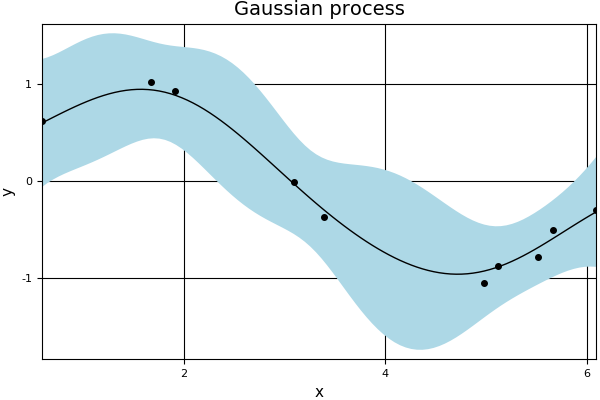

In [6]:
using Plots  #Load Plots.jl package

plot(gp; xlabel="x", ylabel="y", title="Gaussian process", legend=false, fmt=:png)      #Plot the GP

The hyperparameters are optimized using the [Optim.jl](https://github.com/JuliaOpt/Optim.jl) package. This offers users a range of optimization algorithms which can be applied to estimate the hyperparameters using type II maximum likelihood estimation. Gradients are available for all mean and kernel functions used in the package and therefore it is recommended that the user utilizes gradient based optimization techniques. As a default, the `optimize!` function uses the `L-BFGS` solver, however, alternative solvers can be applied. 

In [7]:
optimize!(gp; method=Optim.BFGS())   #Optimise the hyperparameters

LoadError: type UnitializedOnceDifferentiable has no field last_x_f

In [15]:
plot(gp)   #Plot the GP after the hyperparameters have been optimised 

LoadError: In convertToAnyVector, could not handle the argument types: (GaussianProcesses.GP,)

## Multi-dimensional regression

The regression example above can be easily extended to higher dimensions. For the purpose of visualisation, and without loss of generality, we consider a 2 dimensional regression example.

In [16]:
#Training data
d, n = 2, 50;         #Dimension and number of observations
x = 2π * rand(d, n);                               #Predictors
y = vec(sin.(x[1,:]).*sin.(x[2,:])) + 0.05*rand(n);  #Responses

For problems of dimension>1 we can use isotropic (`Iso`) kernels or automatic relevance determination (`ARD`) kernels. For `Iso` kernels, the length scale parameter $\ell$ is the same for all dimensions. For `ARD` kernels, each dimension has different length scale parameter.

The `Iso` and `ARD` kernels are implemented automatically by replacing the single length scale parameter with a vector of parameters. For example, below we use the Matern 5/2 `ARD` kernel, if we wanted to use the `Iso` alternative then we would set the kernel as `kern=Mat(5/2,0.0,0.0)`.

In this example we use a composite kernel represented as the sum of a Matern 5/2 ARD kernel and a Squared Exponential isotropic kernel. This is easily implemented using the `+` symbol, or in the case of a product kernel, using the `*` symbol (i.e. `kern = Mat(5/2,[0.0,0.0],0.0) * SE(0.0,0.0)`).

In [17]:
mZero = MeanZero()                             # Zero mean function
kern = Matern(5/2,[0.0,0.0],0.0) + SE(0.0,0.0)    # Sum kernel with Matern 5/2 ARD kernel 
                                               # with parameters [log(ℓ₁), log(ℓ₂)] = [0,0] and log(σ) = 0
                                               # and Squared Exponential Iso kernel with
                                               # parameters log(ℓ) = 0 and log(σ) = 0

LoadError: UndefVarError: Matern not defined

Fit the Gaussian process to the data using the prespecfied mean and covariance functions.

In [18]:
gp = GP(x,y,mZero,kern,-2.0)          # Fit the GP

GP object:
  Dim = 2
  Number of observations = 50
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [0.0]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [0.0,0.0]
  Input observations = 
[1.43935 0.515919 … 0.487943 2.38029; 4.21509 3.59947 … 0.699132 4.09243]
  Output observations = [-0.850956,-0.173897,0.555086,-0.579203,-0.116111,-0.304235,-0.192372,-0.55408,0.649668,-0.226597  …  -0.874219,-0.136116,0.485536,0.571545,-0.387655,0.200481,-0.33697,0.395318,0.340145,-0.545092]
  Variance of observation noise = 0.01831563888873418
  Marginal Log-Likelihood = -4.802

Using the [Optim](https://github.com/JuliaOpt/Optim.jl) package we have the option to choose from a range of optimize functions including conjugate gradients. It is also possible to fix the hyperparameters in either the mean function, kernel function or observation noise, by settting them to false in `optimize!` (e.g. `optimize!(...,mean=false)`).

In [19]:
optimize!(gp)                         # Optimize the hyperparameters

LoadError: UndefVarError: DifferentiableFunction not defined

A range of plotting options are availbe through the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package.

In [20]:
plot(contour(gp) ,heatmap(gp))

LoadError: In convertToAnyVector, could not handle the argument types: (GaussianProcesses.GP,)